# GRU-RNN Modell mit den neu aufbereiteten Daten im Zuge der Thesis
Hierbei wurde ein GRU-RNN Modell trainiert mit den neu aufbereiteten Daten im Zuge dieser Thesis. Die Aufteilung in Trainings- und Testdaten ist hierbei im Dokument enthalten, da kein Shuffle enthalten ist und die Zeitreihendaten sortiert sind (Split immer an derselben Stelle). Man hätte diesen Prozess auslagern können, bedingt durch Google Colab war es jedoch einfacher den Prozess in den einzelnen Dokumenten zu behalten.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout, CuDNNGRU, CuDNNLSTM, Bidirectional
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     |████████████████████████████████| 98 kB 3.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
FILE_NAME = "data_without_weather.csv"
FS_ROOT_PATH = '/content/drive/MyDrive/sensalytics/Rohdaten/'
CSV_PATH = FS_ROOT_PATH + FILE_NAME

## Data-Import:

In [ ]:
dataset = pd.read_csv(filepath_or_buffer=CSV_PATH, index_col='Date_Time')
dataset.head(5)

,Visitor In,Visitor Out,Ø Occupancy,POS served,Ø Total Occupancy (Payer),Month,Weekday,Weekend,Hour
Date_Time,,,,,,,,,
2021-08-12 06:56:00,1,1,0,0,0,8,3,0,6
2021-08-12 06:58:00,0,1,0,2,0,8,3,0,6
2021-08-12 06:59:00,1,1,0,0,0,8,3,0,6
2021-08-12 07:00:00,2,0,1,0,0,8,3,0,7
2021-08-12 07:01:00,3,0,4,0,0,8,3,0,7


In [ ]:
dataset.index = pd.to_datetime(dataset.index)

Hier wird die Label-Spalte vom Dataset getrennt.

In [ ]:
dataset.pop('Month')
y = dataset.pop('Ø Total Occupancy (Payer)')
display(y.head(5))

Date_Time
2021-08-12 06:56:00    0
2021-08-12 06:58:00    0
2021-08-12 06:59:00    0
2021-08-12 07:00:00    0
2021-08-12 07:01:00    0
Name: Ø Total Occupancy (Payer), dtype: int64

## Modell mit Sliding Window (Many-To-One trainieren):


Hier wird der Dataset in Trainings- und Testdaten eingeteilt. Dabei ist wichtig das Flag *shuffle=False* zu setzen, damit die Daten nicht gemischt werden. Danach werden die Daten mit Hilfe des **StandardScaler()** oder des **MinMaxScaler()** scaliert. Das verbessert das Training, da sich der Wertebereich der Features nicht so groß unterscheidet.

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(dataset, y, test_size=0.2, random_state=0, shuffle=False)

input_scaler = MinMaxScaler()

input_scaler.fit(train_x, train_y)

train_x = input_scaler.transform(train_x)
test_x = input_scaler.transform(test_x)

Die Eingabe für jede RNN-Schicht muss dreidimensional sein. <br>
Die drei Dimensionen dieser Eingabe sind:

- **Samples:** Eine Sequenz ist eine Probe. Eine Batch besteht aus einer oder mehreren Proben.
- **Time Steps:** Ein Zeitschritt ist ein Beobachtungspunkt in der Stichprobe.
- **Features.** Ein Merkmal ist eine Beobachtung pro Zeitschritt.

---

Im *Many-To-One*-Ansatz werden hier die Daten mit dem Sliding-Window verfahren angepasst. Hierbei werden die letzten **n** Timestamps genommen um die nächsten **m** Timestamps vorherzusagen. Mit der Funktion *to_supervised()* werden die Tranings- und Testdaten deshalb angepasst. 

In [ ]:
N_INPUT = 180
M_OUTPUT = 10
FEATURES = dataset.shape[1]
EPOCHS = 100
BATCH_SIZE = 128

In [ ]:
def to_supervised(data, label, n_input, output_ix):
	X, y = list(), list()
	ix_start = 0
	# step over the entire history one time step at a time
	for i in range(len(label)):
		# define the end of the input sequence
		ix_end = ix_start + n_input
		ix_output = ix_end + output_ix
		# ensure we have enough data for this instance
		if ix_output < len(label):
			X.append(data[ix_start:ix_end])
			y.append(label[ix_end:ix_output])
		# move along one time step
		ix_start += 1
	return np.array(X), np.array(y)

In [ ]:
train_x, train_y = to_supervised(train_x, train_y.values, N_INPUT, M_OUTPUT)
test_x, test_y = to_supervised(test_x, test_y.values, N_INPUT, M_OUTPUT)
print("train_x Shape:", train_x.shape)
print("train_y Shape:", train_y.shape)
print("test_x Shape:", test_x.shape)
print("test_y Shape:", test_y.shape)

train_x Shape: (67502, 180, 7)
train_y Shape: (67502, 10)
test_x Shape: (16733, 180, 7)
test_y Shape: (16733, 10)


Implementierung eines Modells ohne die Optimierung der Parameter zum Testen:

In [ ]:
# GRU-RNN Many-To-One Model
model_1 = Sequential()
model_1.add(GRU(64, input_shape=(N_INPUT, FEATURES), return_sequences=False))
model_1.add(Dense(64))
model_1.add(Dense(M_OUTPUT))

model_1.compile(loss='mse', optimizer='Adam', metrics=['mae', 'mse'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnngru (CuDNNGRU)        (None, 64)                14016     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 18,826
Trainable params: 18,826
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model_1.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[early_stop])

Epoch 1/100
528/528 [==============================] - 11s 11ms/step - loss: 21.4089 - mae: 3.4228 - mse: 21.4089 - val_loss: 11.7882 - val_mae: 2.6418 - val_mse: 11.7882
Epoch 2/100
528/528 [==============================] - 6s 11ms/step - loss: 11.5601 - mae: 2.5910 - mse: 11.5601 - val_loss: 10.8266 - val_mae: 2.5412 - val_mse: 10.8266
Epoch 3/100
528/528 [==============================] - 5s 10ms/step - loss: 10.8266 - mae: 2.5066 - mse: 10.8266 - val_loss: 10.4072 - val_mae: 2.4584 - val_mse: 10.4072
Epoch 4/100
528/528 [==============================] - 5s 10ms/step - loss: 10.3426 - mae: 2.4498 - mse: 10.3426 - val_loss: 10.8357 - val_mae: 2.5810 - val_mse: 10.8357
Epoch 5/100
528/528 [==============================] - 5s 10ms/step - loss: 10.1347 - mae: 2.4274 - mse: 10.1347 - val_loss: 9.8365 - val_mae: 2.3716 - val_mse: 9.8365
Epoch 6/100
528/528 [==============================] - 5s 10ms/step - loss: 9.9526 - mae: 2.4066 - mse: 9.9526 - val_loss: 10.2650 - val_mae: 2.4621 - 

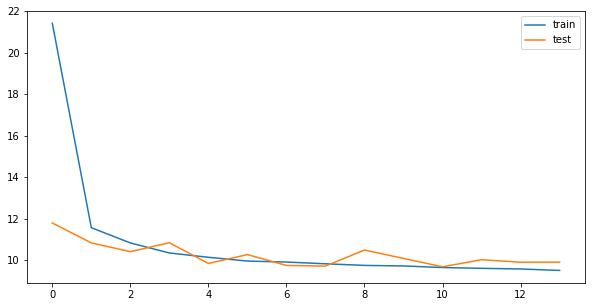

In [ ]:
# plot history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
loss, mae, mse = model_1.evaluate(test_x, test_y, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

523/523 - 2s - loss: 9.8974 - mae: 2.3791 - mse: 9.8974 - 2s/epoch - 4ms/step
Testing set Mean Abs Error:  2.38 MPG


In [ ]:
y_hat = model_1.predict(test_x)
y_hat = y_hat.clip(min=0)

In [ ]:
def calculate_metrics(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  rmsle = mean_squared_log_error(y_true, y_pred, squared=False)
  mae = mean_absolute_error(y_true, y_pred)
  med = median_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  
  return {'MSE': mse, 'RMSE': rmse, 'RMSLE': rmsle, 'MAE':mae, 'MED':med, 'R2':r2}

def evaluate_model(y_true, y_pred):
  df_scores = pd.DataFrame(columns=['MSE', 'RMSE', 'RMSLE', 'MAE', 'MED', 'R2'])

  # Berechnung der Metrics über die einzelnen Vorhersagen
  for i in range(y_true.shape[1]):
    score = pd.Series(calculate_metrics(y_true[:, i], y_pred[:, i]), name='min' + str(i+1) + ':')
    df_scores = df_scores.append(score)
  
  # Berechnugn der Metrics über alle Vorhersagen
  scores_total = pd.Series(calculate_metrics(y_true, y_pred), name='total:')
  df_scores= df_scores.append(scores_total)

  return df_scores

In [ ]:
df_scores = evaluate_model(test_y, y_hat)
display(df_scores)

,MSE,RMSE,RMSLE,MAE,MED,R2
min1:,9.155905,3.025873,0.386757,2.277460,1.784623,0.752774
min2:,9.484545,3.079699,0.394199,2.319166,1.808063,0.743931
min3:,9.678341,3.111003,0.395839,2.343579,1.831406,0.738730
min4:,9.843857,3.137492,0.398767,2.363028,1.854885,0.734288
min5:,9.962747,3.156382,0.400763,2.378303,1.851185,0.731103
min6:,9.997250,3.161843,0.401108,2.381448,1.864101,0.730196
min7:,10.101457,3.178279,0.403259,2.394317,1.867845,0.727413
min8:,10.180818,3.190739,0.405071,2.406002,1.865678,0.725305
min9:,10.200039,3.193750,0.404587,2.405906,1.872467,0.724821
min10:,10.285799,3.207148,0.406450,2.417754,1.876680,0.722542


In [ ]:
np.std(test_y)

6.087091183799563

In [ ]:
def plot_all_predictions(y_pred, y_true):
  # Flatten of the predictions, and get the every 10th
  prediction = y_pred.flatten()[0::10]
  true = y_true.flatten()[0::10]

  plt.figure(figsize=(25,8))
  plt.title("Vergleich der Vorhersagen:")
  plt.plot(true, color='orange', linestyle='-', label='True')
  plt.plot(prediction, color='green', linestyle='--', label='Pred')
  plt.xlabel('Minuten')
  plt.ylabel('Personen im Kassenbereich')
  plt.legend()
  plt.grid()
  plt.show()

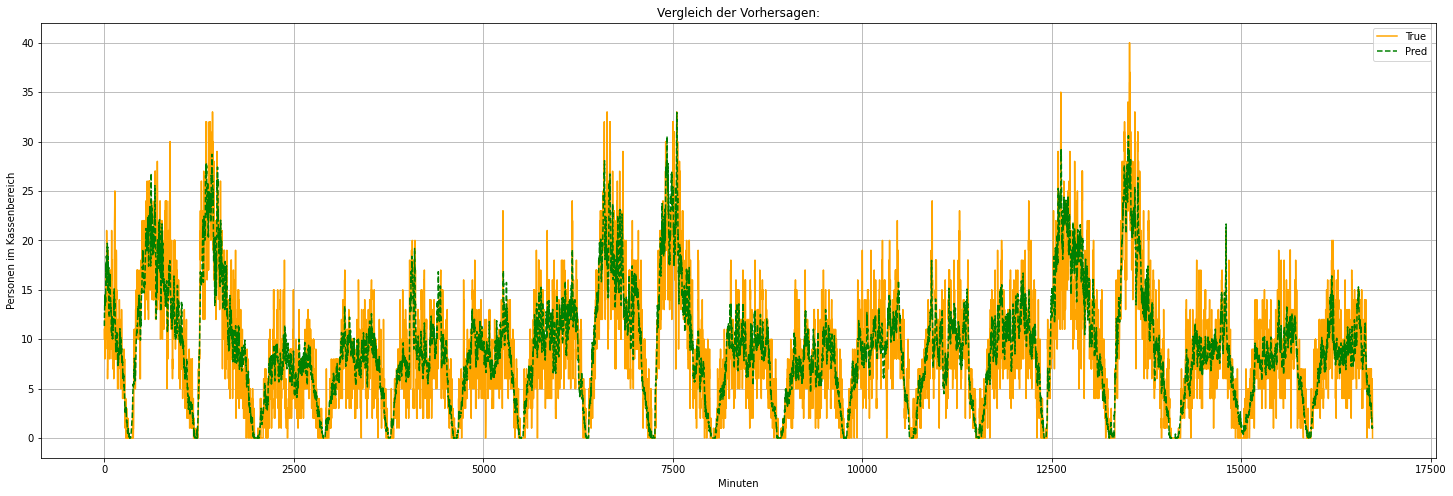

In [ ]:
plot_all_predictions(y_hat, test_y)

### Tuning der Hyperparameter mit Hilfe eines Keras Tuners
Das Tuning der Hyperparameter wurde mit zwei RNN-Schichten durchgeführt, da eine Schicht schlechtere Ergbenisse lieferte.

In [ ]:
def build_model(hp):
  # Sequential Model:
  model = Sequential()

  # Input GRU-Layer with Input-Shape:
  model.add(GRU(
    units=hp.Int('layer_1_units',  min_value=8, max_value=128, step=8), 
    input_shape=(N_INPUT, FEATURES),
    return_sequences=True
  ))

  # Second GRU-Layer
  model.add(GRU(
    units=hp.Int('layer_2_units', min_value=8, max_value=128, step=8)
  ))

  # Dropout-Layer:
  if hp.Boolean('dropout'):
    model.add(
      Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, default=0.0, step=0.1)
    ))

  # Dense Layer with units:
  model.add(Dense(
    units=hp.Int('units_dense', min_value=32, max_value=512, step=32)
  ))

  # Dense Layer with Output-Shape:
  model.add(Dense(
    units=M_OUTPUT
  ))

  # Configuration of optimizer and learnrate:
  model.compile(
    loss = 'mse', 
    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])),  
    metrics=['mae', 'mse'])  

  return model

#### RandomSearch:

In [ ]:
ran_tuner = kt.RandomSearch(hypermodel=build_model, objective="val_loss", max_trials=75, seed=1111, project_name="ran_project")
ran_tuner.search_space_summary()

Search space summary
Default search space size: 5
layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
layer_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
units_dense (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
ran_tuner.search(train_x, train_y, validation_data=(test_x, test_y), epochs=EPOCHS, batch_size=128, callbacks=[early_stop, keras.callbacks.TensorBoard("/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/tmp/new/tb_logs_ran")])

# Retrieve the best model.s
ran_model = ran_tuner.get_best_models(num_models=1)[0]

Trial 75 Complete [00h 01m 43s]
val_loss: 10.091337203979492

Best val_loss So Far: 9.711289405822754
Total elapsed time: 02h 27m 38s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get best parameters
ran_parameters = ran_tuner.get_best_hyperparameters(num_trials=1)[0]

ran_parameters.values

{'dropout': True,
 'dropout_rate': 0.30000000000000004,
 'layer_1_units': 64,
 'layer_2_units': 32,
 'learning_rate': 0.001,
 'units_dense': 224}

In [ ]:
ran_model.save('/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/ran_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/ran_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/ran_model/assets


#### BayesianOptimazation:

In [ ]:
bay_tuner = kt.BayesianOptimization(build_model, max_trials=75, objective='val_loss', seed=1112, project_name="bay_project")
bay_tuner.search_space_summary()

Search space summary
Default search space size: 5
layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
layer_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
units_dense (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
bay_tuner.search(train_x, train_y, validation_data=(test_x, test_y), epochs=EPOCHS, batch_size=128, callbacks=[early_stop, keras.callbacks.TensorBoard("/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/tmp/new/tb_logs_bay")])

# Retrieve the best model.s
bay_model = bay_tuner.get_best_models(num_models=1)[0]

Trial 75 Complete [00h 00m 50s]
val_loss: 10.309141159057617

Best val_loss So Far: 9.577840805053711
Total elapsed time: 03h 24m 13s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get best parameters
bay_parameters = bay_tuner.get_best_hyperparameters(num_trials=1)[0]

bay_parameters.values

{'dropout': True,
 'dropout_rate': 0.0,
 'layer_1_units': 128,
 'layer_2_units': 128,
 'learning_rate': 0.0001,
 'units_dense': 512}

In [ ]:
bay_model.save('/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/bay_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/bay_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/bay_model/assets


#### Hyperband:

In [ ]:
hyp_tuner = kt.Hyperband(hypermodel=build_model, objective='val_mse', max_epochs=75, seed=1113)
hyp_tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


Search space summary
Default search space size: 6
layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
layer_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
units_dense (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
hyp_tuner.search(train_x, train_y, validation_data=(test_x, test_y), batch_size=128, callbacks=[early_stop, keras.callbacks.TensorBoard("/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/tmp/new/tb_logs_hyp")])

# Retrieve the best model.s
hyp_model = hyp_tuner.get_best_models(num_models=1)[0]

Trial 91 Complete [00h 01m 09s]
val_mse: 37.38376998901367

Best val_mse So Far: 9.787137985229492
Total elapsed time: 01h 32m 50s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get best parameters
hyp_parameters = hyp_tuner.get_best_hyperparameters(num_trials=1)[0]

hyp_parameters.values

{'dropout': False,
 'dropout_rate': 0.30000000000000004,
 'layer_1_units': 80,
 'layer_2_units': 64,
 'learning_rate': 0.001,
 'tuner/bracket': 3,
 'tuner/epochs': 9,
 'tuner/initial_epoch': 3,
 'tuner/round': 1,
 'tuner/trial_id': '58bed96ce97658fefcf4744ead8d2c30',
 'units_dense': 384}

In [ ]:
hyp_model.save('/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/hyp_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/hyp_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/hyp_model/assets
